In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#konlpy 설치
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 6.1 MB/s 
     |████████████████████████████████| 453 kB 58.0 MB/s 


In [ ]:
#필요한 라이브러리 임포트
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import *
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/CUAI/CUAI/하계 프로젝트/'

In [ ]:
#데이터 로드
data = pd.read_excel(path + 'final_data.xlsx', engine='openpyxl')

In [ ]:
data = data.drop_duplicates(subset=['document'], ignore_index=True)

In [ ]:
data1 = data['document']
label = data['label']
x_train, x_test, y_train, y_test = train_test_split(data1, label, test_size = 0.25, random_state=42, shuffle = True, stratify = label)

# 형태소 분석
- 불용어 제거 방법  
  - 형태소 분석 시 품사 태깅을 활용하자.
    - 품사 태깅을 진행하고  
     조사, 접사, 접두사, 접미사를 제거하고 단어사전을 생성. 

In [ ]:
okt = Okt()
#부착되는 품사 태그 기호와 의미 확인
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [ ]:
#train_data 형태소 분석
stopwords = ['ㅋ', 'ㅎ', 'ㅠ', 'ㅡ', 'ㅉ']
stoptags = ['Josa', 'Eomi', 'Suffix']
train_data = []

for sent in tqdm(x_train):
    tokenized_sent = okt.pos(sent)
    stopwords_removed_sent = [word[0] for word in tokenized_sent if (not word[1] in stoptags) and (not word[0] in stopwords)]
    train_data.append(stopwords_removed_sent)

100%|██████████| 219829/219829 [10:08<00:00, 361.47it/s]


In [ ]:
#test data 형태소 분석
test_data = []

for sent in tqdm(x_test):
    tokenized_sent = okt.pos(sent)
    stopwords_removed_sent = [word[0] for word in tokenized_sent if (not word[1] in stoptags) and (not word[0] in stopwords)]
    test_data.append(stopwords_removed_sent)

100%|██████████| 73277/73277 [03:55<00:00, 311.39it/s]


## 테스트

In [ ]:
stopwords = ['ㅋ', 'ㅎ', 'ㅠ', 'ㅡ', 'ㅉ']
stoptags = ['Josa', 'Eomi', 'Suffix']

sent = '와 이게 정말 사실이야ㅠ?'
tokenized_sent = okt.pos(sent)
stopwords_removed_sent = [word[0] for word in tokenized_sent if (not word[1] in stoptags) or (not word[0] in stopwords)]

In [ ]:
stopwords_removed_sent

In [ ]:
stopwords_removed_sent2 = [word[0] for word in tokenized_sent if (not word[1] in stoptags) or (word[0] in stopwords)]
stopwords_removed_sent2

In [ ]:
okt.pos(sent)

In [ ]:
stopwords_removed_sent3 = [word[0] for word in tokenized_sent if (not word[1] in stoptags) and (not word[0] in stopwords)]
stopwords_removed_sent3

# 정수인코딩 & 패딩
- 패딩은 텐서플로 tokenizer의 paddding을 사용 => option은 pre로 설정
- 패딩의 길이
  1. 95%를 포함하는 길이 => 약 28~30
  2. 평균 길이로 해보기

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data) 

In [ ]:
len(tokenizer.word_index) #단어 수

92645

In [ ]:
tokenizer.word_index

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 92645
등장 빈도가 2번 이하인 희귀 단어의 수: 57161
단어 집합에서 희귀 단어의 비율: 61.698958389551514
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.222050191502216


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
vocab_size

35485

In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(train_data) 

In [ ]:
X_train = tokenizer.texts_to_sequences(train_data)
X_train

In [ ]:
X_test = tokenizer.texts_to_sequences(test_data)

In [ ]:
X_test

In [ ]:
#X_train결측치 확인
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] 
len(drop_train)

347

In [ ]:
#모두 넘파이 배열로 바꿔준다.
X_train = np.array(X_train)
Y_train = np.array(y_train)
X_test = np.array(X_test)
Y_test = np.array(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
#Train데이터의 결측치 제거
X_train = np.delete(X_train, drop_train, axis=0)
Y_train = np.delete(Y_train, drop_train, axis=0)

In [ ]:
#X_test결측치 확인
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1] 

#test데이터의 결측치 제거
X_test = np.delete(X_test, drop_test, axis=0)
Y_test = np.delete(Y_test, drop_test, axis=0)

### 패딩

최대 길이 : 66
평균 길이 : 9.546254362544536


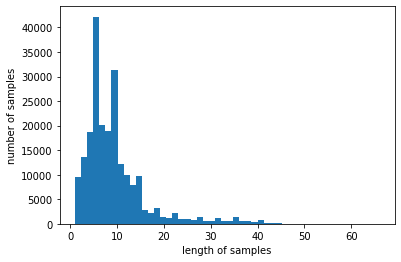

In [ ]:
print('최대 길이 :',max(len(review) for review in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 25
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 95.11941753765684


In [ ]:
#패딩 => 길이는 30
X_train = pad_sequences(X_train, maxlen=max_len, padding='pre')
print(X_train)

#파일로 저장
np.save(path + 'X_train_padding.npy', X_train)

[[    0     0     0 ...    91  1114  6087]
 [    0     0     0 ...   114   882  3215]
 [    0     0     0 ...  2454  2346     6]
 ...
 [    0     0     0 ...   101     2  2197]
 [    0     0     0 ...   415    89   134]
 [    0     0     0 ...   613 11719  6464]]


In [ ]:
X_test = pad_sequences(X_test, maxlen =max_len, padding = 'pre')
print(X_test)

#파일로 저장 
np.save(path + 'X_test_padding.npy', X_test)

[[    0     0     0 ...   287  1405 12744]
 [    0     0     0 ...    37     1 14499]
 [    0     0     0 ...  5575  5462     1]
 ...
 [    0     0     0 ...   130  7137    19]
 [    0     0     0 ...   519     2  2667]
 [    0     0     0 ...    40   697   326]]
